In [31]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
rfm_raw_data = pd.read_pickle('Data/clevertap.pkl')
registration = pd.read_csv('Data/Registration.csv')

In [3]:
registration_sample = registration.sample(n=2000, random_state=0)
filter_data = rfm_raw_data['UserId'].isin(registration_sample['UserId'].values.tolist())
data_sample = rfm_raw_data[filter_data]

In [4]:
data_sample.head()

,Category,Country,Date,Device,Event,Genre,Minute_Of_Day,OS,ProgramType,Second,State,Status,UserId,VideoId,timestamp
1607,NaN,1,20170106,1,AppLaunched,NaN,288,1,NaN,24,35,NaN,bae9dc46d75296e2f5b3457ff846a23a,NaN,2017-01-06 04:48:24
2364,NaN,1,20170106,1,AppLaunched,NaN,459,1,NaN,40,38,NaN,1e1243a821b5000ee90c2660a56d07d8,NaN,2017-01-06 07:39:40
3254,NaN,40,20170106,1,AppLaunched,NaN,565,1,NaN,16,46,NaN,fc8c912c4b15f89c89491d4fe7dae268,NaN,2017-01-06 09:25:16
4409,NaN,40,20170106,1,AppLaunched,NaN,666,1,NaN,12,33,NaN,fa5f4d157bbb5209045c21763be050cf,NaN,2017-01-06 11:06:12
4515,NaN,40,20170106,1,AppLaunched,NaN,674,1,NaN,0,46,NaN,fc8c912c4b15f89c89491d4fe7dae268,NaN,2017-01-06 11:14:00


In [5]:
data_sample['Event'].value_counts()

VideoDetails      35790
AppLaunched       18970
VideoStarted      17239
Registration       4244
UTMVisited         3010
AppUninstalled     1484
Name: Event, dtype: int64

In [6]:
# Initializing required filters
app_launch_filter = data_sample['Event']=='AppLaunched'
video_detail_filter = data_sample['Event']=='VideoDetails'
video_started_filter = data_sample['Event']=='VideoStarted'
utm_visited_filter = data_sample['Event'] == 'UTMVisited'
# initializing RFM Dataframe
# data_sample.drop(['Date','Minute_Of_Day','Second'],axis=1,inplace=True)

In [7]:
max_date = data_sample.timestamp.max()
recencyData = data_sample[app_launch_filter | video_detail_filter | video_started_filter | utm_visited_filter]
def getRecencyData(user):
    userData = recencyData[recencyData['UserId']==user]
    recent_date = userData.timestamp.max()
    recency = (max_date - recent_date)
    return (recency.days + ((recency.seconds/3600)/24))


frequencyData = data_sample[app_launch_filter]
def getFrequency(user):
    userFrequencyData = frequencyData[frequencyData['UserId']==user]
    frequency = len(userFrequencyData)
    return frequency    

engagementData1 = data_sample[video_detail_filter]
engagementData2 = data_sample[video_started_filter]    
def getEngagement(user):
    data1 = engagementData1[engagementData1['UserId']==user]
    data2 = engagementData2[engagementData2['UserId']==user]
    engagement = (0.3*len(data1)) + (0.7*len(data2))
    return engagement

In [8]:
def getRFMDataframe(data_sample):
    rfm_sample = pd.DataFrame()
    rfm_sample['UserId'] = registration_sample['UserId'].values
    rfm_sample['Recency'] = 0
    rfm_sample['Frequency'] = 0
    rfm_sample['Engagement'] = 0
    # Recency
    rfm_sample['Recency'] = rfm_sample['UserId'].apply(getRecencyData) 

    # Freqency
    rfm_sample['Frequency'] = rfm_sample['UserId'].apply(getFrequency) 
    # Engagement
    rfm_sample['Engagement'] = rfm_sample['UserId'].apply(getEngagement) 
        
    return rfm_sample

In [9]:
rfm_sample = getRFMDataframe(data_sample)

In [10]:
rfm_sample.head()

,UserId,Recency,Frequency,Engagement
0,d536ce2236ffa3d83f179754a409405a,115.186806,17,12.4
1,2839586022ec876bf14ac5445e23f703,22.134074,8,0.6
2,87d1e57b45b1cd6da07eb629c6767c90,2.972037,75,176.1
3,b905bc1b49123bb976b469ecc5f91f02,35.082824,1,0.0
4,8f53c22c066b359cc712d6032454c7d8,86.125972,4,0.6


In [11]:
rfm_raw_data.head()

,Category,Country,Date,Device,Event,Genre,Minute_Of_Day,OS,ProgramType,Second,State,Status,UserId,VideoId,timestamp
0,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,4,50,NaN,a27134c322d4f56dabc106a6847cb96b,NaN,2017-01-06 00:00:04
1,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,8,40,NaN,aab39ad0874c59cc388525d511667f9d,NaN,2017-01-06 00:00:08
2,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,12,35,NaN,f717dc3f757dc18cc0c3f27ed3e94ef8,NaN,2017-01-06 00:00:12
3,NaN,1,20170106,2,AppLaunched,NaN,0,2,NaN,20,40,NaN,04c1e14fd54a06c0d4fe98cf0cb8b04c,NaN,2017-01-06 00:00:20
4,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,20,35,NaN,71f05822bb699a04b694dd30265fdf73,NaN,2017-01-06 00:00:20


In [12]:
# Deriving a datetime object.
import datetime as dtp
import time
from time import mktime
from datetime import datetime

def createTimeStamp(row):
    #convert minute of day to hh:mm:ss format
    timeFormatted = dtp.timedelta(minutes=int(row.Minute_Of_Day), seconds=int(row.Second))
    timeVariable = time.strptime(str(row.Date)+" "+str(timeFormatted),'%Y%m%d %H:%M:%S')
    dt = datetime.fromtimestamp(mktime(timeVariable))
    return dt

In [13]:
rfm_sample.head()

,UserId,Recency,Frequency,Engagement
0,d536ce2236ffa3d83f179754a409405a,115.186806,17,12.4
1,2839586022ec876bf14ac5445e23f703,22.134074,8,0.6
2,87d1e57b45b1cd6da07eb629c6767c90,2.972037,75,176.1
3,b905bc1b49123bb976b469ecc5f91f02,35.082824,1,0.0
4,8f53c22c066b359cc712d6032454c7d8,86.125972,4,0.6


In [14]:
video_started = pd.read_csv('Data/VideoStarted.csv')

In [15]:
is_video_watched = rfm_sample['UserId'].isin(video_started['UserId'].values.tolist())

In [16]:
is_video_watched.iloc[0]

True

In [17]:
def get_target_watched(rfm_sample):
    rfm_sample['target_video_watched'] = 0
    for i in range(len(rfm_sample)):
        if(is_video_watched.iloc[i]==True):
            rfm_sample['target_video_watched'].iloc[i] = 1

In [18]:
get_target_watched(rfm_sample)

In [19]:
rfm_sample.head()

,UserId,Recency,Frequency,Engagement,target_video_watched
0,d536ce2236ffa3d83f179754a409405a,115.186806,17,12.4,1
1,2839586022ec876bf14ac5445e23f703,22.134074,8,0.6,0
2,87d1e57b45b1cd6da07eb629c6767c90,2.972037,75,176.1,1
3,b905bc1b49123bb976b469ecc5f91f02,35.082824,1,0.0,0
4,8f53c22c066b359cc712d6032454c7d8,86.125972,4,0.6,0


In [20]:
rfm_sample.head()

,UserId,Recency,Frequency,Engagement,target_video_watched
0,d536ce2236ffa3d83f179754a409405a,115.186806,17,12.4,1
1,2839586022ec876bf14ac5445e23f703,22.134074,8,0.6,0
2,87d1e57b45b1cd6da07eb629c6767c90,2.972037,75,176.1,1
3,b905bc1b49123bb976b469ecc5f91f02,35.082824,1,0.0,0
4,8f53c22c066b359cc712d6032454c7d8,86.125972,4,0.6,0


In [21]:
rfm_raw_data.head()

,Category,Country,Date,Device,Event,Genre,Minute_Of_Day,OS,ProgramType,Second,State,Status,UserId,VideoId,timestamp
0,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,4,50,NaN,a27134c322d4f56dabc106a6847cb96b,NaN,2017-01-06 00:00:04
1,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,8,40,NaN,aab39ad0874c59cc388525d511667f9d,NaN,2017-01-06 00:00:08
2,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,12,35,NaN,f717dc3f757dc18cc0c3f27ed3e94ef8,NaN,2017-01-06 00:00:12
3,NaN,1,20170106,2,AppLaunched,NaN,0,2,NaN,20,40,NaN,04c1e14fd54a06c0d4fe98cf0cb8b04c,NaN,2017-01-06 00:00:20
4,NaN,1,20170106,1,AppLaunched,NaN,0,2,NaN,20,35,NaN,71f05822bb699a04b694dd30265fdf73,NaN,2017-01-06 00:00:20


In [22]:
data = rfm_raw_data[rfm_raw_data['UserId'].isin(rfm_sample['UserId'].values.tolist())][['UserId','timestamp']]

In [23]:
max_date = max(data.timestamp)

In [24]:
max_date - rfm_raw_data.timestamp.iloc[0]

Timedelta('157 days 23:51:16')

In [25]:
from datetime import timedelta
rfm_sample['target_video_watched_2days'] = 0
for user in rfm_sample.UserId.values.tolist():
    user_data = rfm_raw_data[(rfm_raw_data['Event']=='VideoStarted') & (rfm_raw_data.UserId==user)]
    if(len(user_data) != 0):
        time_delta = max_date - max(user_data.timestamp)
        if(time_delta < timedelta(days=2)):
            rfm_sample.loc[rfm_sample.UserId==user,'target_video_watched_2days'] = 1

In [26]:
rfm_sample.head()

,UserId,Recency,Frequency,Engagement,target_video_watched,target_video_watched_2days
0,d536ce2236ffa3d83f179754a409405a,115.186806,17,12.4,1,0
1,2839586022ec876bf14ac5445e23f703,22.134074,8,0.6,0,0
2,87d1e57b45b1cd6da07eb629c6767c90,2.972037,75,176.1,1,0
3,b905bc1b49123bb976b469ecc5f91f02,35.082824,1,0.0,0,0
4,8f53c22c066b359cc712d6032454c7d8,86.125972,4,0.6,0,0


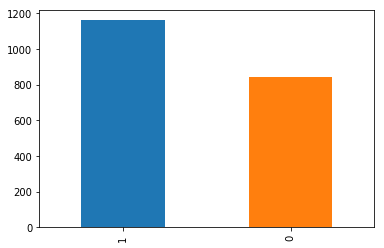

In [33]:
rfm_sample.target_video_watched.value_counts().plot(kind='bar')

In [29]:
rfm_sample.to_csv('rfm_sample.csv')

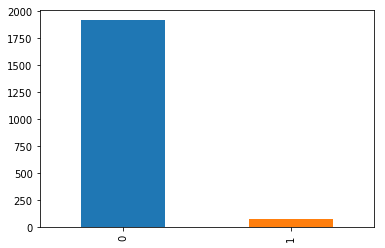

In [34]:
rfm_sample.target_video_watched_2days.value_counts().plot(kind='bar')